In [1]:
%matplotlib inline

# Transit fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

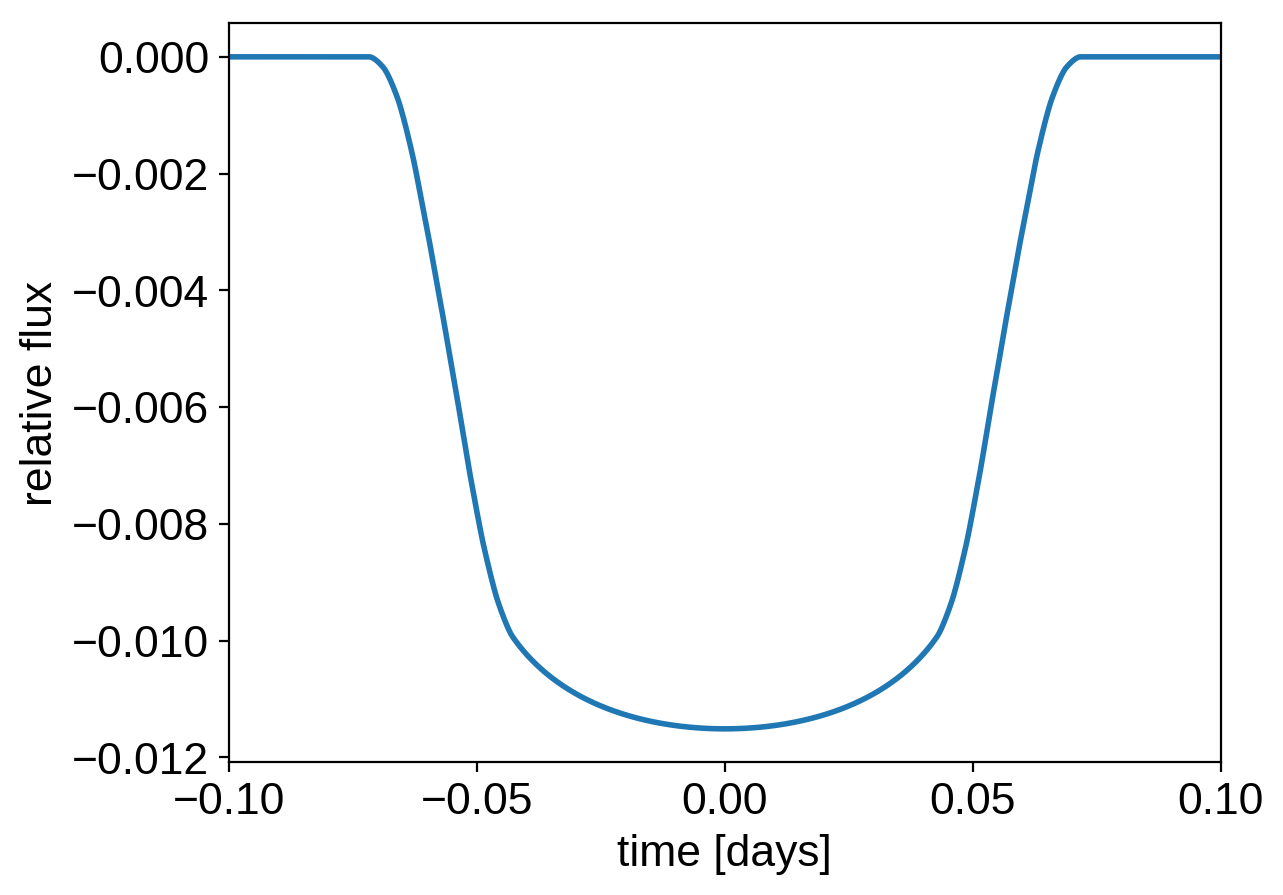

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = xo.LimbDarkLightCurve(u).get_light_curve(
    orbit=orbit, r=0.1, t=t, texp=0.02).eval()
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009) and for the joint radius ratio and impact parameter distribution we'll use the parameterization from [Espinoza (2018)](https://arxiv.org/abs/1811.04859).
Both of these reparameterizations are implemented in *exoplanet* as custom *PyMC3* distributions (:class:`exoplanet.distributions.QuadLimbDark` and :class:`exoplanet.distributions.RadiusImpact` respectively).

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.01, max_radius=0.1,
        testval_r=np.array([0.04, 0.06]),
        testval_b=np.random.rand(2)
    )
    
    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)
    
    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)
    
    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 24793.972586707856 -> 24799.526978939874


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

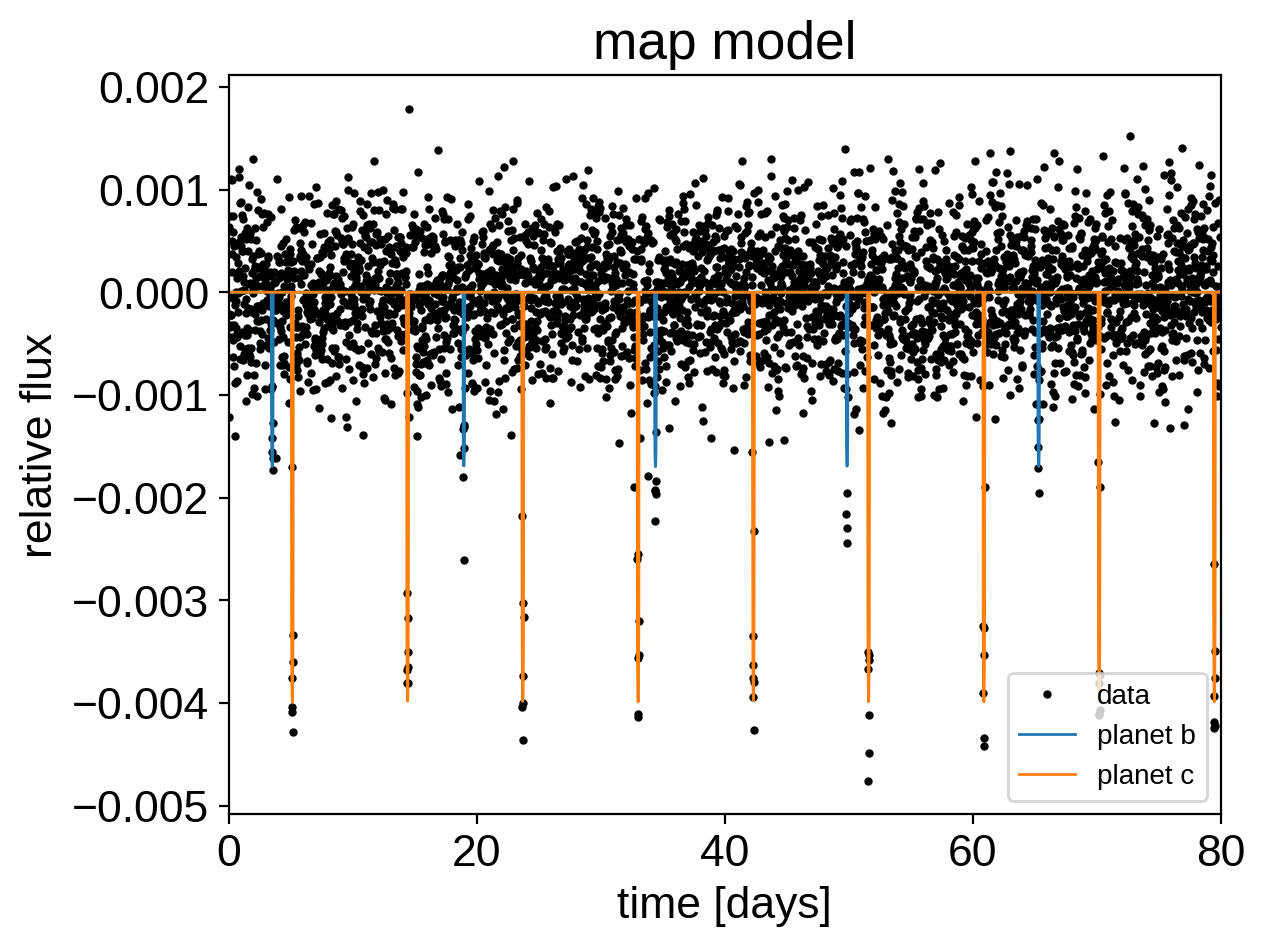

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1,
             label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use the :class:`exoplanet.PyMC3Sampler` to sample.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200, chains=4)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:00<00:02, 142.56draws/s]

Sampling 4 chains:   8%|▊         | 26/308 [00:00<00:03, 80.31draws/s] 

Sampling 4 chains:  10%|█         | 31/308 [00:00<00:04, 56.26draws/s]

Sampling 4 chains:  11%|█▏        | 35/308 [00:00<00:05, 46.22draws/s]

Sampling 4 chains:  13%|█▎        | 39/308 [00:00<00:06, 41.06draws/s]

Sampling 4 chains:  14%|█▍        | 43/308 [00:00<00:06, 38.07draws/s]

Sampling 4 chains:  15%|█▌        | 47/308 [00:00<00:07, 36.24draws/s]

Sampling 4 chains:  17%|█▋        | 51/308 [00:01<00:07, 35.04draws/s]

Sampling 4 chains:  18%|█▊        | 55/308 [00:01<00:07, 34.51draws/s]

Sampling 4 chains:  19%|█▉        | 60/308 [00:01<00:06, 36.40draws/s]

Sampling 4 chains:  21%|██        | 64/308 [00:01<00:06, 35.43draws/s]

Sampling 4 chains:  22%|██▏       | 68/308 [00:01<00:06, 34.79draws/s]

Sampling 4 chains:  23%|██▎       | 72/308 [00:01<00:06, 34.35draws/s]

Sampling 4 chains:  25%|██▍       | 76/308 [00:01<00:06, 34.05draws/s]

Sampling 4 chains:  26%|██▌       | 80/308 [00:01<00:06, 33.86draws/s]

Sampling 4 chains:  27%|██▋       | 84/308 [00:01<00:06, 33.72draws/s]

Sampling 4 chains:  29%|██▊       | 88/308 [00:02<00:06, 32.72draws/s]

Sampling 4 chains:  30%|██▉       | 92/308 [00:02<00:06, 33.01draws/s]

Sampling 4 chains:  31%|███       | 96/308 [00:02<00:06, 33.23draws/s]

Sampling 4 chains:  32%|███▏      | 100/308 [00:02<00:06, 33.13draws/s]

Sampling 4 chains:  34%|███▍      | 104/308 [00:02<00:06, 33.18draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:02<00:06, 33.22draws/s]

Sampling 4 chains:  36%|███▋      | 112/308 [00:02<00:05, 33.26draws/s]

Sampling 4 chains:  38%|███▊      | 116/308 [00:02<00:05, 33.28draws/s]

Sampling 4 chains:  39%|███▉      | 120/308 [00:03<00:05, 33.29draws/s]

Sampling 4 chains:  41%|████      | 125/308 [00:03<00:05, 35.36draws/s]

Sampling 4 chains:  42%|████▏     | 129/308 [00:03<00:05, 34.72draws/s]

Sampling 4 chains:  44%|████▎     | 134/308 [00:03<00:04, 36.53draws/s]

Sampling 4 chains:  45%|████▍     | 138/308 [00:03<00:04, 35.50draws/s]

Sampling 4 chains:  46%|████▌     | 142/308 [00:03<00:04, 34.81draws/s]

Sampling 4 chains:  47%|████▋     | 146/308 [00:03<00:04, 34.34draws/s]

Sampling 4 chains:  49%|████▊     | 150/308 [00:03<00:04, 34.01draws/s]

Sampling 4 chains:  50%|█████     | 154/308 [00:04<00:04, 33.80draws/s]

Sampling 4 chains:  51%|█████▏    | 158/308 [00:04<00:04, 33.53draws/s]

Sampling 4 chains:  53%|█████▎    | 162/308 [00:04<00:04, 33.45draws/s]

Sampling 4 chains:  54%|█████▍    | 166/308 [00:04<00:04, 33.41draws/s]

Sampling 4 chains:  55%|█████▌    | 170/308 [00:04<00:04, 33.39draws/s]

Sampling 4 chains:  56%|█████▋    | 174/308 [00:04<00:04, 32.20draws/s]

Sampling 4 chains:  58%|█████▊    | 178/308 [00:04<00:03, 32.51draws/s]

Sampling 4 chains:  59%|█████▉    | 182/308 [00:04<00:03, 32.73draws/s]

Sampling 4 chains:  60%|██████    | 186/308 [00:05<00:03, 32.89draws/s]

Sampling 4 chains:  62%|██████▏   | 190/308 [00:05<00:03, 33.01draws/s]

Sampling 4 chains:  63%|██████▎   | 194/308 [00:05<00:03, 32.79draws/s]

Sampling 4 chains:  64%|██████▍   | 198/308 [00:05<00:03, 32.94draws/s]

Sampling 4 chains:  66%|██████▌   | 202/308 [00:05<00:03, 33.03draws/s]

Sampling 4 chains:  67%|██████▋   | 206/308 [00:05<00:03, 33.12draws/s]

Sampling 4 chains:  68%|██████▊   | 210/308 [00:05<00:02, 33.17draws/s]

Sampling 4 chains:  69%|██████▉   | 214/308 [00:05<00:02, 33.22draws/s]

Sampling 4 chains:  71%|███████   | 218/308 [00:05<00:02, 33.23draws/s]

Sampling 4 chains:  72%|███████▏  | 222/308 [00:06<00:02, 33.26draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [00:06<00:02, 33.29draws/s]

Sampling 4 chains:  75%|███████▍  | 230/308 [00:06<00:02, 34.71draws/s]

Sampling 4 chains:  76%|███████▌  | 234/308 [00:06<00:02, 33.88draws/s]

Sampling 4 chains:  77%|███████▋  | 238/308 [00:06<00:02, 33.41draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:06<00:01, 33.21draws/s]

Sampling 4 chains:  80%|███████▉  | 246/308 [00:06<00:01, 33.05draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:06<00:01, 32.93draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [00:07<00:01, 32.83draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [00:07<00:01, 32.77draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [00:07<00:01, 32.72draws/s]

Sampling 4 chains:  86%|████████▋ | 266/308 [00:07<00:01, 32.83draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [00:07<00:01, 32.96draws/s]

Sampling 4 chains:  89%|████████▉ | 274/308 [00:07<00:01, 32.97draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [00:07<00:00, 32.92draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [00:07<00:00, 32.81draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:08<00:00, 32.73draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:08<00:00, 32.68draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:08<00:00, 32.65draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:08<00:00, 32.62draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:08<00:00, 32.28draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:09<00:00, 17.54draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:09<00:00, 33.57draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:02, 136.88draws/s]

Sampling 4 chains:   6%|▋         | 26/408 [00:00<00:05, 74.10draws/s] 

Sampling 4 chains:   7%|▋         | 30/408 [00:00<00:07, 53.63draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:00<00:08, 46.61draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:00<00:09, 41.02draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:00<00:08, 40.72draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:00<00:09, 37.66draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:01<00:09, 35.80draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:01<00:09, 37.00draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:01<00:09, 35.39draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:01<00:09, 34.42draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:01<00:08, 37.79draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:01<00:09, 36.10draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:01<00:08, 37.41draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:01<00:09, 35.81draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:02<00:09, 34.82draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:02<00:08, 36.43draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:02<00:08, 35.22draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:02<00:08, 35.87draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:02<00:08, 34.35draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:02<00:08, 33.36draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:02<00:08, 34.90draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:02<00:08, 34.02draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:02<00:07, 35.81draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:03<00:07, 38.97draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:03<00:06, 39.32draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:03<00:07, 37.39draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:03<00:06, 37.87draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:03<00:06, 38.20draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:03<00:07, 35.81draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:03<00:06, 36.55draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:04<00:06, 37.46draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:04<00:06, 38.22draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:04<00:06, 38.77draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:04<00:05, 39.03draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:04<00:06, 36.73draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:04<00:06, 35.27draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:04<00:06, 34.32draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:04<00:06, 33.66draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:05<00:06, 33.23draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:05<00:06, 32.94draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:05<00:05, 34.86draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:05<00:05, 34.05draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:05<00:05, 33.50draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:05<00:05, 33.11draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:05<00:05, 32.87draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [00:05<00:05, 32.69draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:06<00:05, 32.55draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:06<00:05, 33.96draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:06<00:04, 35.21draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [00:06<00:04, 33.97draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:06<00:04, 33.14draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:06<00:04, 36.36draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:06<00:04, 34.70draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:06<00:04, 35.94draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:07<00:03, 36.86draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [00:07<00:03, 35.03draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:07<00:03, 36.32draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:07<00:03, 35.23draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:07<00:03, 36.80draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:07<00:03, 35.53draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:07<00:03, 34.70draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:07<00:03, 36.24draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:08<00:03, 35.19draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:08<00:02, 36.78draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:08<00:02, 35.53draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:08<00:02, 34.69draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:08<00:02, 34.13draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:08<00:02, 37.61draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:08<00:02, 36.06draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:08<00:02, 35.04draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:08<00:02, 34.36draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:09<00:01, 33.84draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:09<00:01, 35.73draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:09<00:01, 34.84draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:09<00:01, 36.08draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [00:09<00:01, 34.52draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:09<00:01, 34.96draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:09<00:01, 35.64draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:09<00:01, 34.55draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:10<00:01, 33.84draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:10<00:00, 33.36draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [00:10<00:00, 33.04draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:10<00:00, 32.82draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [00:10<00:00, 36.32draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:10<00:00, 35.03draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:11<00:00, 21.76draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:11<00:00, 22.25draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:11<00:00, 17.57draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:12<00:00, 33.90draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<01:44,  7.70draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<01:15, 10.61draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:00<01:00, 13.05draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:00<00:47, 16.67draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:00<00:40, 19.46draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:34, 22.65draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:00<00:30, 25.64draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:00<00:25, 29.94draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:01<00:25, 30.59draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:01<00:24, 31.04draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:01<00:20, 37.44draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:01<00:19, 38.24draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:01<00:18, 40.97draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:01<00:18, 40.24draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:01<00:18, 38.87draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:01<00:17, 40.41draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:02<00:18, 38.75draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:02<00:17, 40.55draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:02<00:18, 38.76draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:02<00:16, 42.70draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:02<00:16, 41.76draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:02<00:17, 40.67draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:02<00:16, 42.10draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:02<00:16, 40.59draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:03<00:16, 42.37draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:03<00:16, 41.62draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:03<00:17, 38.71draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:03<00:16, 40.53draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:03<00:15, 41.29draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:03<00:17, 37.63draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:03<00:16, 40.31draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:03<00:15, 41.74draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:04<00:16, 39.88draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:04<00:16, 39.56draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:04<00:15, 40.22draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:04<00:16, 38.43draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:04<00:16, 37.07draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:04<00:15, 39.01draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:04<00:16, 36.63draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:04<00:14, 42.28draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:05<00:14, 41.45draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:05<00:13, 43.24draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:05<00:12, 46.85draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:05<00:12, 46.69draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:05<00:12, 44.45draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:05<00:12, 45.57draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:05<00:12, 43.86draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:05<00:13, 42.57draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:06<00:12, 43.62draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:06<00:12, 43.74draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:06<00:13, 39.63draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:06<00:13, 39.46draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:06<00:13, 39.68draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:06<00:13, 39.93draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:06<00:13, 39.93draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:06<00:12, 40.24draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:07<00:11, 43.34draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:07<00:14, 35.76draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:07<00:13, 36.25draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:07<00:13, 37.62draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:07<00:12, 39.29draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:07<00:12, 39.41draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:07<00:11, 42.58draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:08<00:11, 40.02draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:08<00:11, 40.52draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:08<00:11, 41.95draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:08<00:11, 41.26draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:08<00:11, 39.55draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:08<00:11, 39.01draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:08<00:11, 37.91draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:08<00:10, 40.47draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:09<00:10, 39.98draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:09<00:10, 41.84draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:09<00:10, 40.64draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:09<00:10, 39.95draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:09<00:10, 37.89draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:09<00:10, 37.93draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:09<00:11, 36.68draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:09<00:10, 37.58draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [00:10<00:10, 38.26draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:10<00:11, 35.64draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:10<00:10, 38.63draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:10<00:08, 43.14draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:10<00:08, 46.27draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:10<00:09, 39.65draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:10<00:07, 48.38draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:10<00:07, 48.09draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:11<00:07, 46.83draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [00:11<00:08, 42.19draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:11<00:07, 42.59draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:11<00:07, 43.84draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:11<00:07, 44.06draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:11<00:06, 48.84draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:11<00:06, 46.63draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:11<00:06, 47.16draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:12<00:06, 44.66draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:12<00:06, 48.15draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:12<00:06, 42.58draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:12<00:06, 45.80draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:12<00:05, 49.78draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:12<00:05, 45.17draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:12<00:06, 43.44draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:12<00:06, 41.76draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:13<00:05, 42.48draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [00:13<00:05, 45.06draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:13<00:05, 41.50draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:13<00:05, 43.38draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:13<00:04, 47.34draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:13<00:04, 46.85draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:13<00:05, 42.99draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:14<00:05, 41.53draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:14<00:04, 42.93draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [00:14<00:05, 38.77draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:14<00:04, 46.64draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [00:14<00:04, 44.98draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:14<00:04, 38.07draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:14<00:03, 43.82draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [00:15<00:04, 40.52draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:15<00:04, 40.26draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [00:15<00:03, 40.64draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:15<00:03, 44.83draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:15<00:03, 46.92draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:15<00:03, 44.43draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:15<00:02, 47.03draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:15<00:03, 40.65draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:16<00:03, 40.34draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [00:16<00:03, 38.60draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:16<00:03, 36.31draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:16<00:02, 41.44draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [00:16<00:02, 40.99draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [00:16<00:02, 37.16draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [00:16<00:02, 36.85draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:17<00:02, 40.02draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [00:17<00:01, 40.07draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:17<00:01, 39.11draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:17<00:01, 40.54draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:17<00:01, 40.42draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [00:17<00:01, 39.25draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:17<00:01, 40.80draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:17<00:01, 38.77draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:18<00:00, 42.68draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:18<00:00, 37.70draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:18<00:00, 41.56draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:18<00:00, 41.20draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:18<00:00, 36.46draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:18<00:00, 32.99draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:19<00:00, 30.90draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:19<00:00, 33.69draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:19<00:00, 31.89draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:19<00:00, 41.32draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:00<00:04, 322.59draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:00<00:04, 334.53draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:00<00:04, 365.77draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:00<00:03, 383.60draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:00<00:03, 407.00draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [00:00<00:03, 436.49draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:00<00:02, 445.00draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [00:00<00:02, 471.45draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [00:00<00:02, 467.84draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:01<00:02, 462.26draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [00:01<00:02, 479.12draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [00:01<00:02, 495.70draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [00:01<00:02, 486.55draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [00:01<00:01, 503.71draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [00:01<00:01, 518.92draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [00:01<00:01, 524.16draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [00:01<00:01, 513.79draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [00:01<00:01, 536.30draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [00:01<00:01, 545.03draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [00:02<00:01, 553.72draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [00:02<00:00, 546.27draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [00:02<00:00, 549.69draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [00:02<00:00, 560.44draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [00:02<00:00, 558.79draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [00:02<00:00, 534.71draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [00:02<00:00, 539.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [00:02<00:00, 515.23draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [00:02<00:00, 523.62draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [00:02<00:00, 523.61draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [00:03<00:00, 526.93draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 482.88draws/s]

Sampling 4 chains:   0%|          | 0/6908 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 33/6908 [00:00<00:21, 325.10draws/s]

Sampling 4 chains:   1%|          | 72/6908 [00:00<00:20, 341.52draws/s]

Sampling 4 chains:   2%|▏         | 111/6908 [00:00<00:19, 352.13draws/s]

Sampling 4 chains:   2%|▏         | 145/6908 [00:00<00:19, 345.36draws/s]

Sampling 4 chains:   3%|▎         | 179/6908 [00:00<00:19, 343.42draws/s]

Sampling 4 chains:   3%|▎         | 213/6908 [00:00<00:19, 340.85draws/s]

Sampling 4 chains:   4%|▎         | 254/6908 [00:00<00:18, 357.95draws/s]

Sampling 4 chains:   4%|▍         | 298/6908 [00:00<00:17, 376.41draws/s]

Sampling 4 chains:   5%|▌         | 346/6908 [00:00<00:16, 402.36draws/s]

Sampling 4 chains:   6%|▌         | 386/6908 [00:01<00:16, 397.74draws/s]

Sampling 4 chains:   6%|▌         | 431/6908 [00:01<00:15, 412.00draws/s]

Sampling 4 chains:   7%|▋         | 473/6908 [00:01<00:15, 413.20draws/s]

Sampling 4 chains:   8%|▊         | 520/6908 [00:01<00:15, 425.57draws/s]

Sampling 4 chains:   8%|▊         | 565/6908 [00:01<00:14, 431.36draws/s]

Sampling 4 chains:   9%|▉         | 614/6908 [00:01<00:14, 447.00draws/s]

Sampling 4 chains:  10%|▉         | 659/6908 [00:01<00:14, 436.37draws/s]

Sampling 4 chains:  10%|█         | 707/6908 [00:01<00:13, 448.30draws/s]

Sampling 4 chains:  11%|█         | 756/6908 [00:01<00:13, 459.64draws/s]

Sampling 4 chains:  12%|█▏        | 814/6908 [00:01<00:12, 488.64draws/s]

Sampling 4 chains:  13%|█▎        | 867/6908 [00:02<00:12, 499.31draws/s]

Sampling 4 chains:  13%|█▎        | 918/6908 [00:02<00:12, 489.95draws/s]

Sampling 4 chains:  14%|█▍        | 969/6908 [00:02<00:12, 494.80draws/s]

Sampling 4 chains:  15%|█▍        | 1019/6908 [00:02<00:11, 492.06draws/s]

Sampling 4 chains:  15%|█▌        | 1069/6908 [00:02<00:12, 477.26draws/s]

Sampling 4 chains:  16%|█▌        | 1117/6908 [00:02<00:12, 463.88draws/s]

Sampling 4 chains:  17%|█▋        | 1168/6908 [00:02<00:12, 475.79draws/s]

Sampling 4 chains:  18%|█▊        | 1221/6908 [00:02<00:11, 486.50draws/s]

Sampling 4 chains:  18%|█▊        | 1270/6908 [00:02<00:11, 486.14draws/s]

Sampling 4 chains:  19%|█▉        | 1323/6908 [00:02<00:11, 497.42draws/s]

Sampling 4 chains:  20%|█▉        | 1374/6908 [00:03<00:11, 499.73draws/s]

Sampling 4 chains:  21%|██        | 1425/6908 [00:03<00:11, 490.32draws/s]

Sampling 4 chains:  21%|██▏       | 1475/6908 [00:03<00:11, 487.72draws/s]

Sampling 4 chains:  22%|██▏       | 1528/6908 [00:03<00:10, 498.29draws/s]

Sampling 4 chains:  23%|██▎       | 1578/6908 [00:03<00:11, 480.05draws/s]

Sampling 4 chains:  24%|██▎       | 1627/6908 [00:03<00:11, 476.30draws/s]

Sampling 4 chains:  24%|██▍       | 1680/6908 [00:03<00:10, 489.68draws/s]

Sampling 4 chains:  25%|██▌       | 1732/6908 [00:03<00:10, 497.33draws/s]

Sampling 4 chains:  26%|██▌       | 1786/6908 [00:03<00:10, 507.95draws/s]

Sampling 4 chains:  27%|██▋       | 1837/6908 [00:04<00:10, 506.58draws/s]

Sampling 4 chains:  27%|██▋       | 1888/6908 [00:04<00:10, 492.42draws/s]

Sampling 4 chains:  28%|██▊       | 1938/6908 [00:04<00:10, 492.48draws/s]

Sampling 4 chains:  29%|██▉       | 1988/6908 [00:04<00:10, 488.77draws/s]

Sampling 4 chains:  30%|██▉       | 2041/6908 [00:04<00:09, 499.30draws/s]

Sampling 4 chains:  30%|███       | 2092/6908 [00:04<00:09, 495.92draws/s]

Sampling 4 chains:  31%|███       | 2142/6908 [00:04<00:09, 490.31draws/s]

Sampling 4 chains:  32%|███▏      | 2196/6908 [00:04<00:09, 500.25draws/s]

Sampling 4 chains:  33%|███▎      | 2247/6908 [00:04<00:09, 493.10draws/s]

Sampling 4 chains:  33%|███▎      | 2297/6908 [00:04<00:09, 494.75draws/s]

Sampling 4 chains:  34%|███▍      | 2347/6908 [00:05<00:09, 475.42draws/s]

Sampling 4 chains:  35%|███▍      | 2399/6908 [00:05<00:09, 486.59draws/s]

Sampling 4 chains:  36%|███▌      | 2455/6908 [00:05<00:08, 506.04draws/s]

Sampling 4 chains:  36%|███▋      | 2506/6908 [00:05<00:08, 504.89draws/s]

Sampling 4 chains:  37%|███▋      | 2559/6908 [00:05<00:08, 510.25draws/s]

Sampling 4 chains:  38%|███▊      | 2611/6908 [00:05<00:08, 505.31draws/s]

Sampling 4 chains:  39%|███▊      | 2664/6908 [00:05<00:08, 507.86draws/s]

Sampling 4 chains:  39%|███▉      | 2715/6908 [00:05<00:08, 504.55draws/s]

Sampling 4 chains:  40%|████      | 2766/6908 [00:05<00:08, 492.69draws/s]

Sampling 4 chains:  41%|████      | 2816/6908 [00:05<00:08, 493.63draws/s]

Sampling 4 chains:  41%|████▏     | 2866/6908 [00:06<00:08, 491.87draws/s]

Sampling 4 chains:  42%|████▏     | 2918/6908 [00:06<00:07, 498.82draws/s]

Sampling 4 chains:  43%|████▎     | 2968/6908 [00:06<00:07, 496.86draws/s]

Sampling 4 chains:  44%|████▎     | 3019/6908 [00:06<00:07, 499.27draws/s]

Sampling 4 chains:  45%|████▍     | 3077/6908 [00:06<00:07, 520.39draws/s]

Sampling 4 chains:  45%|████▌     | 3135/6908 [00:06<00:07, 536.72draws/s]

Sampling 4 chains:  46%|████▌     | 3189/6908 [00:06<00:06, 537.25draws/s]

Sampling 4 chains:  47%|████▋     | 3243/6908 [00:06<00:06, 525.65draws/s]

Sampling 4 chains:  48%|████▊     | 3297/6908 [00:06<00:06, 528.55draws/s]

Sampling 4 chains:  49%|████▊     | 3351/6908 [00:07<00:06, 526.94draws/s]

Sampling 4 chains:  49%|████▉     | 3404/6908 [00:07<00:06, 527.46draws/s]

Sampling 4 chains:  50%|█████     | 3457/6908 [00:07<00:06, 518.88draws/s]

Sampling 4 chains:  51%|█████     | 3509/6908 [00:07<00:06, 516.29draws/s]

Sampling 4 chains:  52%|█████▏    | 3562/6908 [00:07<00:06, 519.13draws/s]

Sampling 4 chains:  52%|█████▏    | 3614/6908 [00:07<00:06, 509.47draws/s]

Sampling 4 chains:  53%|█████▎    | 3667/6908 [00:07<00:06, 513.91draws/s]

Sampling 4 chains:  54%|█████▍    | 3719/6908 [00:07<00:06, 507.20draws/s]

Sampling 4 chains:  55%|█████▍    | 3770/6908 [00:07<00:06, 482.11draws/s]

Sampling 4 chains:  55%|█████▌    | 3821/6908 [00:07<00:06, 489.97draws/s]

Sampling 4 chains:  56%|█████▌    | 3872/6908 [00:08<00:06, 490.57draws/s]

Sampling 4 chains:  57%|█████▋    | 3927/6908 [00:08<00:05, 504.10draws/s]

Sampling 4 chains:  58%|█████▊    | 3980/6908 [00:08<00:05, 509.50draws/s]

Sampling 4 chains:  58%|█████▊    | 4033/6908 [00:08<00:05, 512.30draws/s]

Sampling 4 chains:  59%|█████▉    | 4086/6908 [00:08<00:05, 516.05draws/s]

Sampling 4 chains:  60%|█████▉    | 4138/6908 [00:08<00:05, 500.07draws/s]

Sampling 4 chains:  61%|██████    | 4189/6908 [00:08<00:05, 490.63draws/s]

Sampling 4 chains:  61%|██████▏   | 4239/6908 [00:08<00:05, 483.68draws/s]

Sampling 4 chains:  62%|██████▏   | 4289/6908 [00:08<00:05, 486.89draws/s]

Sampling 4 chains:  63%|██████▎   | 4340/6908 [00:08<00:05, 493.22draws/s]

Sampling 4 chains:  64%|██████▎   | 4392/6908 [00:09<00:05, 497.69draws/s]

Sampling 4 chains:  64%|██████▍   | 4448/6908 [00:09<00:04, 514.07draws/s]

Sampling 4 chains:  65%|██████▌   | 4500/6908 [00:09<00:04, 508.78draws/s]

Sampling 4 chains:  66%|██████▌   | 4553/6908 [00:09<00:04, 513.74draws/s]

Sampling 4 chains:  67%|██████▋   | 4605/6908 [00:09<00:04, 511.16draws/s]

Sampling 4 chains:  67%|██████▋   | 4657/6908 [00:09<00:04, 512.89draws/s]

Sampling 4 chains:  68%|██████▊   | 4709/6908 [00:09<00:04, 507.40draws/s]

Sampling 4 chains:  69%|██████▉   | 4763/6908 [00:09<00:04, 516.27draws/s]

Sampling 4 chains:  70%|██████▉   | 4816/6908 [00:09<00:04, 519.19draws/s]

Sampling 4 chains:  70%|███████   | 4868/6908 [00:10<00:03, 518.56draws/s]

Sampling 4 chains:  71%|███████   | 4921/6908 [00:10<00:03, 521.67draws/s]

Sampling 4 chains:  72%|███████▏  | 4974/6908 [00:10<00:03, 506.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5025/6908 [00:10<00:03, 498.08draws/s]

Sampling 4 chains:  73%|███████▎  | 5075/6908 [00:10<00:03, 498.57draws/s]

Sampling 4 chains:  74%|███████▍  | 5125/6908 [00:10<00:03, 498.05draws/s]

Sampling 4 chains:  75%|███████▌  | 5182/6908 [00:10<00:03, 510.43draws/s]

Sampling 4 chains:  76%|███████▌  | 5235/6908 [00:10<00:03, 512.45draws/s]

Sampling 4 chains:  77%|███████▋  | 5287/6908 [00:10<00:03, 499.07draws/s]

Sampling 4 chains:  77%|███████▋  | 5338/6908 [00:10<00:03, 499.58draws/s]

Sampling 4 chains:  78%|███████▊  | 5389/6908 [00:11<00:03, 499.35draws/s]

Sampling 4 chains:  79%|███████▊  | 5440/6908 [00:11<00:02, 496.98draws/s]

Sampling 4 chains:  79%|███████▉  | 5490/6908 [00:11<00:02, 488.75draws/s]

Sampling 4 chains:  80%|████████  | 5542/6908 [00:11<00:02, 495.85draws/s]

Sampling 4 chains:  81%|████████  | 5592/6908 [00:11<00:02, 487.47draws/s]

Sampling 4 chains:  82%|████████▏ | 5643/6908 [00:11<00:02, 489.75draws/s]

Sampling 4 chains:  82%|████████▏ | 5696/6908 [00:11<00:02, 499.46draws/s]

Sampling 4 chains:  83%|████████▎ | 5748/6908 [00:11<00:02, 500.69draws/s]

Sampling 4 chains:  84%|████████▍ | 5801/6908 [00:11<00:02, 507.51draws/s]

Sampling 4 chains:  85%|████████▍ | 5857/6908 [00:11<00:02, 521.18draws/s]

Sampling 4 chains:  86%|████████▌ | 5910/6908 [00:12<00:01, 519.37draws/s]

Sampling 4 chains:  86%|████████▋ | 5964/6908 [00:12<00:01, 524.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6018/6908 [00:12<00:01, 527.56draws/s]

Sampling 4 chains:  88%|████████▊ | 6071/6908 [00:12<00:01, 513.83draws/s]

Sampling 4 chains:  89%|████████▊ | 6123/6908 [00:12<00:01, 507.55draws/s]

Sampling 4 chains:  89%|████████▉ | 6174/6908 [00:12<00:01, 507.55draws/s]

Sampling 4 chains:  90%|█████████ | 6225/6908 [00:12<00:01, 507.80draws/s]

Sampling 4 chains:  91%|█████████ | 6276/6908 [00:12<00:01, 493.61draws/s]

Sampling 4 chains:  92%|█████████▏| 6326/6908 [00:12<00:01, 475.62draws/s]

Sampling 4 chains:  92%|█████████▏| 6377/6908 [00:13<00:01, 484.80draws/s]

Sampling 4 chains:  93%|█████████▎| 6428/6908 [00:13<00:00, 491.92draws/s]

Sampling 4 chains:  94%|█████████▍| 6479/6908 [00:13<00:00, 495.44draws/s]

Sampling 4 chains:  95%|█████████▍| 6534/6908 [00:13<00:00, 510.24draws/s]

Sampling 4 chains:  95%|█████████▌| 6586/6908 [00:13<00:00, 500.23draws/s]

Sampling 4 chains:  96%|█████████▌| 6639/6908 [00:13<00:00, 507.13draws/s]

Sampling 4 chains:  97%|█████████▋| 6690/6908 [00:13<00:00, 501.41draws/s]

Sampling 4 chains:  98%|█████████▊| 6741/6908 [00:13<00:00, 501.05draws/s]

Sampling 4 chains:  98%|█████████▊| 6792/6908 [00:13<00:00, 503.23draws/s]

Sampling 4 chains:  99%|█████████▉| 6843/6908 [00:13<00:00, 470.45draws/s]

Sampling 4 chains: 100%|█████████▉| 6891/6908 [00:14<00:00, 285.71draws/s]

Sampling 4 chains: 100%|██████████| 6908/6908 [00:14<00:00, 479.19draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:02, 267.60draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:00<00:02, 278.08draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:00<00:02, 283.59draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:00<00:02, 292.14draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:00<00:02, 305.22draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:00<00:01, 315.78draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:00<00:01, 324.14draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:00<00:01, 332.51draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:00<00:01, 348.94draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:01<00:01, 372.76draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:01<00:00, 409.91draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:01<00:00, 405.36draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [00:01<00:00, 424.69draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:01<00:00, 445.96draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [00:01<00:00, 455.96draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:01<00:00, 470.35draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:01<00:00, 469.22draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:01<00:00, 464.55draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:02<00:00, 312.00draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 349.01draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [rb, u, logP, t0, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 39/12000 [00:00<00:30, 389.44draws/s]

Sampling 4 chains:   1%|          | 88/12000 [00:00<00:28, 411.79draws/s]

Sampling 4 chains:   1%|          | 141/12000 [00:00<00:26, 441.04draws/s]

Sampling 4 chains:   2%|▏         | 194/12000 [00:00<00:25, 461.42draws/s]

Sampling 4 chains:   2%|▏         | 243/12000 [00:00<00:25, 468.51draws/s]

Sampling 4 chains:   2%|▏         | 295/12000 [00:00<00:24, 482.30draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [00:00<00:23, 492.10draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [00:00<00:23, 495.12draws/s]

Sampling 4 chains:   4%|▎         | 448/12000 [00:00<00:23, 494.98draws/s]

Sampling 4 chains:   4%|▍         | 500/12000 [00:01<00:22, 501.17draws/s]

Sampling 4 chains:   5%|▍         | 550/12000 [00:01<00:23, 494.76draws/s]

Sampling 4 chains:   5%|▍         | 599/12000 [00:01<00:23, 490.42draws/s]

Sampling 4 chains:   5%|▌         | 650/12000 [00:01<00:22, 494.69draws/s]

Sampling 4 chains:   6%|▌         | 702/12000 [00:01<00:22, 499.35draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [00:01<00:22, 491.37draws/s]

Sampling 4 chains:   7%|▋         | 802/12000 [00:01<00:22, 493.33draws/s]

Sampling 4 chains:   7%|▋         | 852/12000 [00:01<00:22, 488.53draws/s]

Sampling 4 chains:   8%|▊         | 902/12000 [00:01<00:22, 490.88draws/s]

Sampling 4 chains:   8%|▊         | 954/12000 [00:01<00:22, 497.94draws/s]

Sampling 4 chains:   8%|▊         | 1005/12000 [00:02<00:22, 496.97draws/s]

Sampling 4 chains:   9%|▉         | 1055/12000 [00:02<00:21, 497.80draws/s]

Sampling 4 chains:   9%|▉         | 1105/12000 [00:02<00:21, 498.44draws/s]

Sampling 4 chains:  10%|▉         | 1157/12000 [00:02<00:21, 501.15draws/s]

Sampling 4 chains:  10%|█         | 1208/12000 [00:02<00:21, 502.72draws/s]

Sampling 4 chains:  10%|█         | 1259/12000 [00:02<00:21, 502.59draws/s]

Sampling 4 chains:  11%|█         | 1310/12000 [00:02<00:21, 493.45draws/s]

Sampling 4 chains:  11%|█▏        | 1360/12000 [00:02<00:21, 489.23draws/s]

Sampling 4 chains:  12%|█▏        | 1410/12000 [00:02<00:21, 489.81draws/s]

Sampling 4 chains:  12%|█▏        | 1461/12000 [00:02<00:21, 494.74draws/s]

Sampling 4 chains:  13%|█▎        | 1511/12000 [00:03<00:21, 488.33draws/s]

Sampling 4 chains:  13%|█▎        | 1563/12000 [00:03<00:21, 493.72draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [00:03<00:20, 497.25draws/s]

Sampling 4 chains:  14%|█▍        | 1664/12000 [00:03<00:20, 497.71draws/s]

Sampling 4 chains:  14%|█▍        | 1714/12000 [00:03<00:20, 498.25draws/s]

Sampling 4 chains:  15%|█▍        | 1765/12000 [00:03<00:20, 497.91draws/s]

Sampling 4 chains:  15%|█▌        | 1815/12000 [00:03<00:20, 490.70draws/s]

Sampling 4 chains:  16%|█▌        | 1867/12000 [00:03<00:20, 494.66draws/s]

Sampling 4 chains:  16%|█▌        | 1917/12000 [00:03<00:20, 488.80draws/s]

Sampling 4 chains:  16%|█▋        | 1968/12000 [00:03<00:20, 492.70draws/s]

Sampling 4 chains:  17%|█▋        | 2018/12000 [00:04<00:20, 493.21draws/s]

Sampling 4 chains:  17%|█▋        | 2068/12000 [00:04<00:20, 489.15draws/s]

Sampling 4 chains:  18%|█▊        | 2119/12000 [00:04<00:20, 493.06draws/s]

Sampling 4 chains:  18%|█▊        | 2169/12000 [00:04<00:19, 492.82draws/s]

Sampling 4 chains:  18%|█▊        | 2220/12000 [00:04<00:19, 494.22draws/s]

Sampling 4 chains:  19%|█▉        | 2272/12000 [00:04<00:19, 499.53draws/s]

Sampling 4 chains:  19%|█▉        | 2323/12000 [00:04<00:19, 501.43draws/s]

Sampling 4 chains:  20%|█▉        | 2374/12000 [00:04<00:19, 492.50draws/s]

Sampling 4 chains:  20%|██        | 2426/12000 [00:04<00:19, 498.62draws/s]

Sampling 4 chains:  21%|██        | 2477/12000 [00:05<00:18, 501.54draws/s]

Sampling 4 chains:  21%|██        | 2528/12000 [00:05<00:18, 500.88draws/s]

Sampling 4 chains:  21%|██▏       | 2579/12000 [00:05<00:19, 495.59draws/s]

Sampling 4 chains:  22%|██▏       | 2629/12000 [00:05<00:18, 493.76draws/s]

Sampling 4 chains:  22%|██▏       | 2679/12000 [00:05<00:18, 495.29draws/s]

Sampling 4 chains:  23%|██▎       | 2729/12000 [00:05<00:18, 493.89draws/s]

Sampling 4 chains:  23%|██▎       | 2779/12000 [00:05<00:18, 488.09draws/s]

Sampling 4 chains:  24%|██▎       | 2828/12000 [00:05<00:18, 485.91draws/s]

Sampling 4 chains:  24%|██▍       | 2877/12000 [00:05<00:18, 486.25draws/s]

Sampling 4 chains:  24%|██▍       | 2928/12000 [00:05<00:18, 492.52draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [00:06<00:18, 498.41draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [00:06<00:18, 492.74draws/s]

Sampling 4 chains:  26%|██▌       | 3080/12000 [00:06<00:18, 489.63draws/s]

Sampling 4 chains:  26%|██▌       | 3132/12000 [00:06<00:17, 498.05draws/s]

Sampling 4 chains:  27%|██▋       | 3182/12000 [00:06<00:17, 495.89draws/s]

Sampling 4 chains:  27%|██▋       | 3236/12000 [00:06<00:17, 502.72draws/s]

Sampling 4 chains:  27%|██▋       | 3289/12000 [00:06<00:17, 505.73draws/s]

Sampling 4 chains:  28%|██▊       | 3340/12000 [00:06<00:17, 504.03draws/s]

Sampling 4 chains:  28%|██▊       | 3391/12000 [00:06<00:17, 505.04draws/s]

Sampling 4 chains:  29%|██▊       | 3442/12000 [00:06<00:16, 505.00draws/s]

Sampling 4 chains:  29%|██▉       | 3493/12000 [00:07<00:16, 504.54draws/s]

Sampling 4 chains:  30%|██▉       | 3545/12000 [00:07<00:16, 507.49draws/s]

Sampling 4 chains:  30%|██▉       | 3596/12000 [00:07<00:16, 505.17draws/s]

Sampling 4 chains:  30%|███       | 3647/12000 [00:07<00:16, 503.16draws/s]

Sampling 4 chains:  31%|███       | 3699/12000 [00:07<00:16, 500.87draws/s]

Sampling 4 chains:  31%|███▏      | 3752/12000 [00:07<00:16, 504.23draws/s]

Sampling 4 chains:  32%|███▏      | 3804/12000 [00:07<00:16, 506.75draws/s]

Sampling 4 chains:  32%|███▏      | 3857/12000 [00:07<00:15, 511.02draws/s]

Sampling 4 chains:  33%|███▎      | 3909/12000 [00:07<00:15, 507.86draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [00:07<00:15, 513.92draws/s]

Sampling 4 chains:  33%|███▎      | 4014/12000 [00:08<00:15, 514.99draws/s]

Sampling 4 chains:  34%|███▍      | 4067/12000 [00:08<00:15, 519.09draws/s]

Sampling 4 chains:  34%|███▍      | 4119/12000 [00:08<00:15, 515.18draws/s]

Sampling 4 chains:  35%|███▍      | 4171/12000 [00:08<00:15, 510.56draws/s]

Sampling 4 chains:  35%|███▌      | 4223/12000 [00:08<00:15, 512.64draws/s]

Sampling 4 chains:  36%|███▌      | 4275/12000 [00:08<00:15, 508.39draws/s]

Sampling 4 chains:  36%|███▌      | 4327/12000 [00:08<00:15, 510.05draws/s]

Sampling 4 chains:  36%|███▋      | 4379/12000 [00:08<00:15, 506.41draws/s]

Sampling 4 chains:  37%|███▋      | 4432/12000 [00:08<00:14, 510.33draws/s]

Sampling 4 chains:  37%|███▋      | 4484/12000 [00:08<00:14, 503.67draws/s]

Sampling 4 chains:  38%|███▊      | 4535/12000 [00:09<00:14, 504.84draws/s]

Sampling 4 chains:  38%|███▊      | 4586/12000 [00:09<00:14, 496.71draws/s]

Sampling 4 chains:  39%|███▊      | 4637/12000 [00:09<00:14, 500.19draws/s]

Sampling 4 chains:  39%|███▉      | 4688/12000 [00:09<00:14, 500.02draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [00:09<00:14, 510.35draws/s]

Sampling 4 chains:  40%|███▉      | 4795/12000 [00:09<00:14, 513.96draws/s]

Sampling 4 chains:  40%|████      | 4848/12000 [00:09<00:13, 517.46draws/s]

Sampling 4 chains:  41%|████      | 4900/12000 [00:09<00:13, 509.16draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [00:09<00:13, 505.07draws/s]

Sampling 4 chains:  42%|████▏     | 5002/12000 [00:10<00:13, 503.91draws/s]

Sampling 4 chains:  42%|████▏     | 5053/12000 [00:10<00:13, 504.45draws/s]

Sampling 4 chains:  43%|████▎     | 5104/12000 [00:10<00:13, 503.00draws/s]

Sampling 4 chains:  43%|████▎     | 5155/12000 [00:10<00:13, 500.73draws/s]

Sampling 4 chains:  43%|████▎     | 5206/12000 [00:10<00:13, 498.45draws/s]

Sampling 4 chains:  44%|████▍     | 5256/12000 [00:10<00:13, 493.68draws/s]

Sampling 4 chains:  44%|████▍     | 5307/12000 [00:10<00:13, 497.12draws/s]

Sampling 4 chains:  45%|████▍     | 5358/12000 [00:10<00:13, 500.75draws/s]

Sampling 4 chains:  45%|████▌     | 5409/12000 [00:10<00:13, 495.46draws/s]

Sampling 4 chains:  45%|████▌     | 5459/12000 [00:10<00:13, 492.56draws/s]

Sampling 4 chains:  46%|████▌     | 5509/12000 [00:11<00:13, 486.56draws/s]

Sampling 4 chains:  46%|████▋     | 5558/12000 [00:11<00:13, 484.43draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [00:11<00:13, 483.74draws/s]

Sampling 4 chains:  47%|████▋     | 5658/12000 [00:11<00:12, 491.07draws/s]

Sampling 4 chains:  48%|████▊     | 5708/12000 [00:11<00:12, 491.30draws/s]

Sampling 4 chains:  48%|████▊     | 5759/12000 [00:11<00:12, 495.23draws/s]

Sampling 4 chains:  48%|████▊     | 5811/12000 [00:11<00:12, 502.00draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [00:11<00:12, 497.35draws/s]

Sampling 4 chains:  49%|████▉     | 5912/12000 [00:11<00:12, 491.64draws/s]

Sampling 4 chains:  50%|████▉     | 5963/12000 [00:11<00:12, 494.12draws/s]

Sampling 4 chains:  50%|█████     | 6013/12000 [00:12<00:12, 492.36draws/s]

Sampling 4 chains:  51%|█████     | 6064/12000 [00:12<00:12, 493.68draws/s]

Sampling 4 chains:  51%|█████     | 6115/12000 [00:12<00:11, 497.77draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [00:12<00:11, 503.76draws/s]

Sampling 4 chains:  52%|█████▏    | 6218/12000 [00:12<00:11, 502.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6270/12000 [00:12<00:11, 505.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [00:12<00:11, 510.73draws/s]

Sampling 4 chains:  53%|█████▎    | 6376/12000 [00:12<00:11, 505.57draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [00:12<00:11, 504.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [00:12<00:11, 501.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6529/12000 [00:13<00:11, 496.72draws/s]

Sampling 4 chains:  55%|█████▍    | 6580/12000 [00:13<00:10, 499.97draws/s]

Sampling 4 chains:  55%|█████▌    | 6631/12000 [00:13<00:10, 501.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6682/12000 [00:13<00:10, 500.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6733/12000 [00:13<00:10, 491.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6783/12000 [00:13<00:10, 493.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6835/12000 [00:13<00:10, 498.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [00:13<00:10, 501.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6939/12000 [00:13<00:09, 509.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6991/12000 [00:14<00:09, 510.23draws/s]

Sampling 4 chains:  59%|█████▊    | 7043/12000 [00:14<00:09, 501.90draws/s]

Sampling 4 chains:  59%|█████▉    | 7094/12000 [00:14<00:09, 500.57draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [00:14<00:09, 502.59draws/s]

Sampling 4 chains:  60%|█████▉    | 7199/12000 [00:14<00:09, 506.46draws/s]

Sampling 4 chains:  60%|██████    | 7250/12000 [00:14<00:09, 503.78draws/s]

Sampling 4 chains:  61%|██████    | 7301/12000 [00:14<00:09, 497.04draws/s]

Sampling 4 chains:  61%|██████▏   | 7352/12000 [00:14<00:09, 500.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7403/12000 [00:14<00:09, 488.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7456/12000 [00:14<00:09, 493.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [00:15<00:08, 500.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7562/12000 [00:15<00:08, 511.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7614/12000 [00:15<00:08, 504.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7665/12000 [00:15<00:08, 503.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7716/12000 [00:15<00:08, 497.50draws/s]

Sampling 4 chains:  65%|██████▍   | 7770/12000 [00:15<00:08, 509.26draws/s]

Sampling 4 chains:  65%|██████▌   | 7822/12000 [00:15<00:08, 503.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7873/12000 [00:15<00:08, 501.30draws/s]

Sampling 4 chains:  66%|██████▌   | 7925/12000 [00:15<00:08, 501.86draws/s]

Sampling 4 chains:  66%|██████▋   | 7976/12000 [00:15<00:08, 502.76draws/s]

Sampling 4 chains:  67%|██████▋   | 8029/12000 [00:16<00:07, 506.17draws/s]

Sampling 4 chains:  67%|██████▋   | 8082/12000 [00:16<00:07, 509.37draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [00:16<00:07, 504.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8184/12000 [00:16<00:07, 504.97draws/s]

Sampling 4 chains:  69%|██████▊   | 8235/12000 [00:16<00:07, 506.47draws/s]

Sampling 4 chains:  69%|██████▉   | 8286/12000 [00:16<00:07, 497.89draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [00:16<00:07, 494.73draws/s]

Sampling 4 chains:  70%|██████▉   | 8386/12000 [00:16<00:07, 495.33draws/s]

Sampling 4 chains:  70%|███████   | 8439/12000 [00:16<00:07, 505.02draws/s]

Sampling 4 chains:  71%|███████   | 8490/12000 [00:16<00:06, 504.20draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [00:17<00:06, 515.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8597/12000 [00:17<00:06, 513.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8649/12000 [00:17<00:06, 508.33draws/s]

Sampling 4 chains:  72%|███████▎  | 8700/12000 [00:17<00:06, 501.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8751/12000 [00:17<00:06, 500.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8804/12000 [00:17<00:06, 508.19draws/s]

Sampling 4 chains:  74%|███████▍  | 8855/12000 [00:17<00:06, 504.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8906/12000 [00:17<00:06, 505.61draws/s]

Sampling 4 chains:  75%|███████▍  | 8957/12000 [00:17<00:06, 498.88draws/s]

Sampling 4 chains:  75%|███████▌  | 9012/12000 [00:18<00:05, 513.09draws/s]

Sampling 4 chains:  76%|███████▌  | 9064/12000 [00:18<00:05, 510.09draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [00:18<00:05, 510.34draws/s]

Sampling 4 chains:  76%|███████▋  | 9168/12000 [00:18<00:05, 506.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9219/12000 [00:18<00:05, 505.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9272/12000 [00:18<00:05, 511.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9324/12000 [00:18<00:05, 509.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [00:18<00:05, 506.75draws/s]

Sampling 4 chains:  79%|███████▊  | 9428/12000 [00:18<00:05, 505.55draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [00:18<00:04, 507.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9531/12000 [00:19<00:04, 501.68draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [00:19<00:04, 507.72draws/s]

Sampling 4 chains:  80%|████████  | 9638/12000 [00:19<00:04, 516.34draws/s]

Sampling 4 chains:  81%|████████  | 9690/12000 [00:19<00:04, 516.10draws/s]

Sampling 4 chains:  81%|████████  | 9742/12000 [00:19<00:04, 513.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9794/12000 [00:19<00:04, 512.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [00:19<00:04, 514.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9898/12000 [00:19<00:04, 516.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9950/12000 [00:19<00:04, 512.47draws/s]

Sampling 4 chains:  83%|████████▎ | 10002/12000 [00:19<00:03, 514.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10054/12000 [00:20<00:03, 506.68draws/s]

Sampling 4 chains:  84%|████████▍ | 10105/12000 [00:20<00:03, 507.36draws/s]

Sampling 4 chains:  85%|████████▍ | 10156/12000 [00:20<00:03, 504.89draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [00:20<00:03, 508.92draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [00:20<00:03, 501.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10311/12000 [00:20<00:03, 504.95draws/s]

Sampling 4 chains:  86%|████████▋ | 10362/12000 [00:20<00:03, 501.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [00:20<00:03, 506.61draws/s]

Sampling 4 chains:  87%|████████▋ | 10465/12000 [00:20<00:03, 506.80draws/s]

Sampling 4 chains:  88%|████████▊ | 10516/12000 [00:20<00:02, 503.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10567/12000 [00:21<00:02, 503.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10620/12000 [00:21<00:02, 510.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10672/12000 [00:21<00:02, 512.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10724/12000 [00:21<00:02, 510.24draws/s]

Sampling 4 chains:  90%|████████▉ | 10776/12000 [00:21<00:02, 510.62draws/s]

Sampling 4 chains:  90%|█████████ | 10828/12000 [00:21<00:02, 508.01draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [00:21<00:02, 499.62draws/s]

Sampling 4 chains:  91%|█████████ | 10933/12000 [00:21<00:02, 507.76draws/s]

Sampling 4 chains:  92%|█████████▏| 10985/12000 [00:21<00:01, 511.10draws/s]

Sampling 4 chains:  92%|█████████▏| 11037/12000 [00:21<00:01, 513.61draws/s]

Sampling 4 chains:  92%|█████████▏| 11089/12000 [00:22<00:01, 504.18draws/s]

Sampling 4 chains:  93%|█████████▎| 11140/12000 [00:22<00:01, 496.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11192/12000 [00:22<00:01, 500.22draws/s]

Sampling 4 chains:  94%|█████████▎| 11243/12000 [00:22<00:01, 495.81draws/s]

Sampling 4 chains:  94%|█████████▍| 11293/12000 [00:22<00:01, 481.72draws/s]

Sampling 4 chains:  95%|█████████▍| 11345/12000 [00:22<00:01, 490.54draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [00:22<00:01, 490.97draws/s]

Sampling 4 chains:  95%|█████████▌| 11445/12000 [00:22<00:01, 490.18draws/s]

Sampling 4 chains:  96%|█████████▌| 11495/12000 [00:22<00:01, 491.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11545/12000 [00:23<00:00, 487.03draws/s]

Sampling 4 chains:  97%|█████████▋| 11596/12000 [00:23<00:00, 491.83draws/s]

Sampling 4 chains:  97%|█████████▋| 11648/12000 [00:23<00:00, 497.74draws/s]

Sampling 4 chains:  97%|█████████▋| 11698/12000 [00:23<00:00, 495.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [00:23<00:00, 435.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11793/12000 [00:23<00:00, 410.97draws/s]

Sampling 4 chains:  99%|█████████▊| 11836/12000 [00:23<00:00, 401.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11878/12000 [00:23<00:00, 363.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [00:24<00:00, 313.79draws/s]

Sampling 4 chains: 100%|█████████▉| 11950/12000 [00:24<00:00, 282.24draws/s]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [00:24<00:00, 200.67draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:24<00:00, 487.15draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

mean        sd      mc_error    hpd_2.5   hpd_97.5  \
period__0  15.447914  0.002321  3.659947e-05  15.443122  15.452090   
period__1   9.292474  0.000301  2.808500e-06   9.291887   9.293050   
t0__0       3.503112  0.005837  9.350475e-05   3.492809   3.515157   
t0__1       5.121289  0.001370  1.149626e-05   5.118693   5.124023   
r__0        0.039526  0.001599  2.164871e-05   0.036400   0.042555   
r__1        0.058462  0.001054  1.516423e-05   0.056437   0.060415   
b__0        0.668522  0.047575  8.550631e-04   0.566165   0.738892   
b__1        0.402511  0.038414  5.352225e-04   0.324421   0.467398   
u__0        0.369271  0.206921  2.480988e-03   0.000376   0.727056   
u__1        0.283749  0.340357  4.995744e-03  -0.321040   0.871783   
mean        0.000005  0.000008  6.339271e-08  -0.000011   0.000019   

                  n_eff      Rhat  
period__0   4385.443009  1.000574  
period__1  12151.835330  0.999905  
t0__0       4438.396882  1.000357  
t0__1      13671.770308  0.999898  
r__0        5932.885111  1.000028  
r__1        5619.543688  1.000414  
b__0        3357.794852  1.000184  
b__1        5436.914504  1.000321  
u__0        8685.453309  1.000082  
u__1        5649.580001  1.000259  
mean       15700.073502  1.000068

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

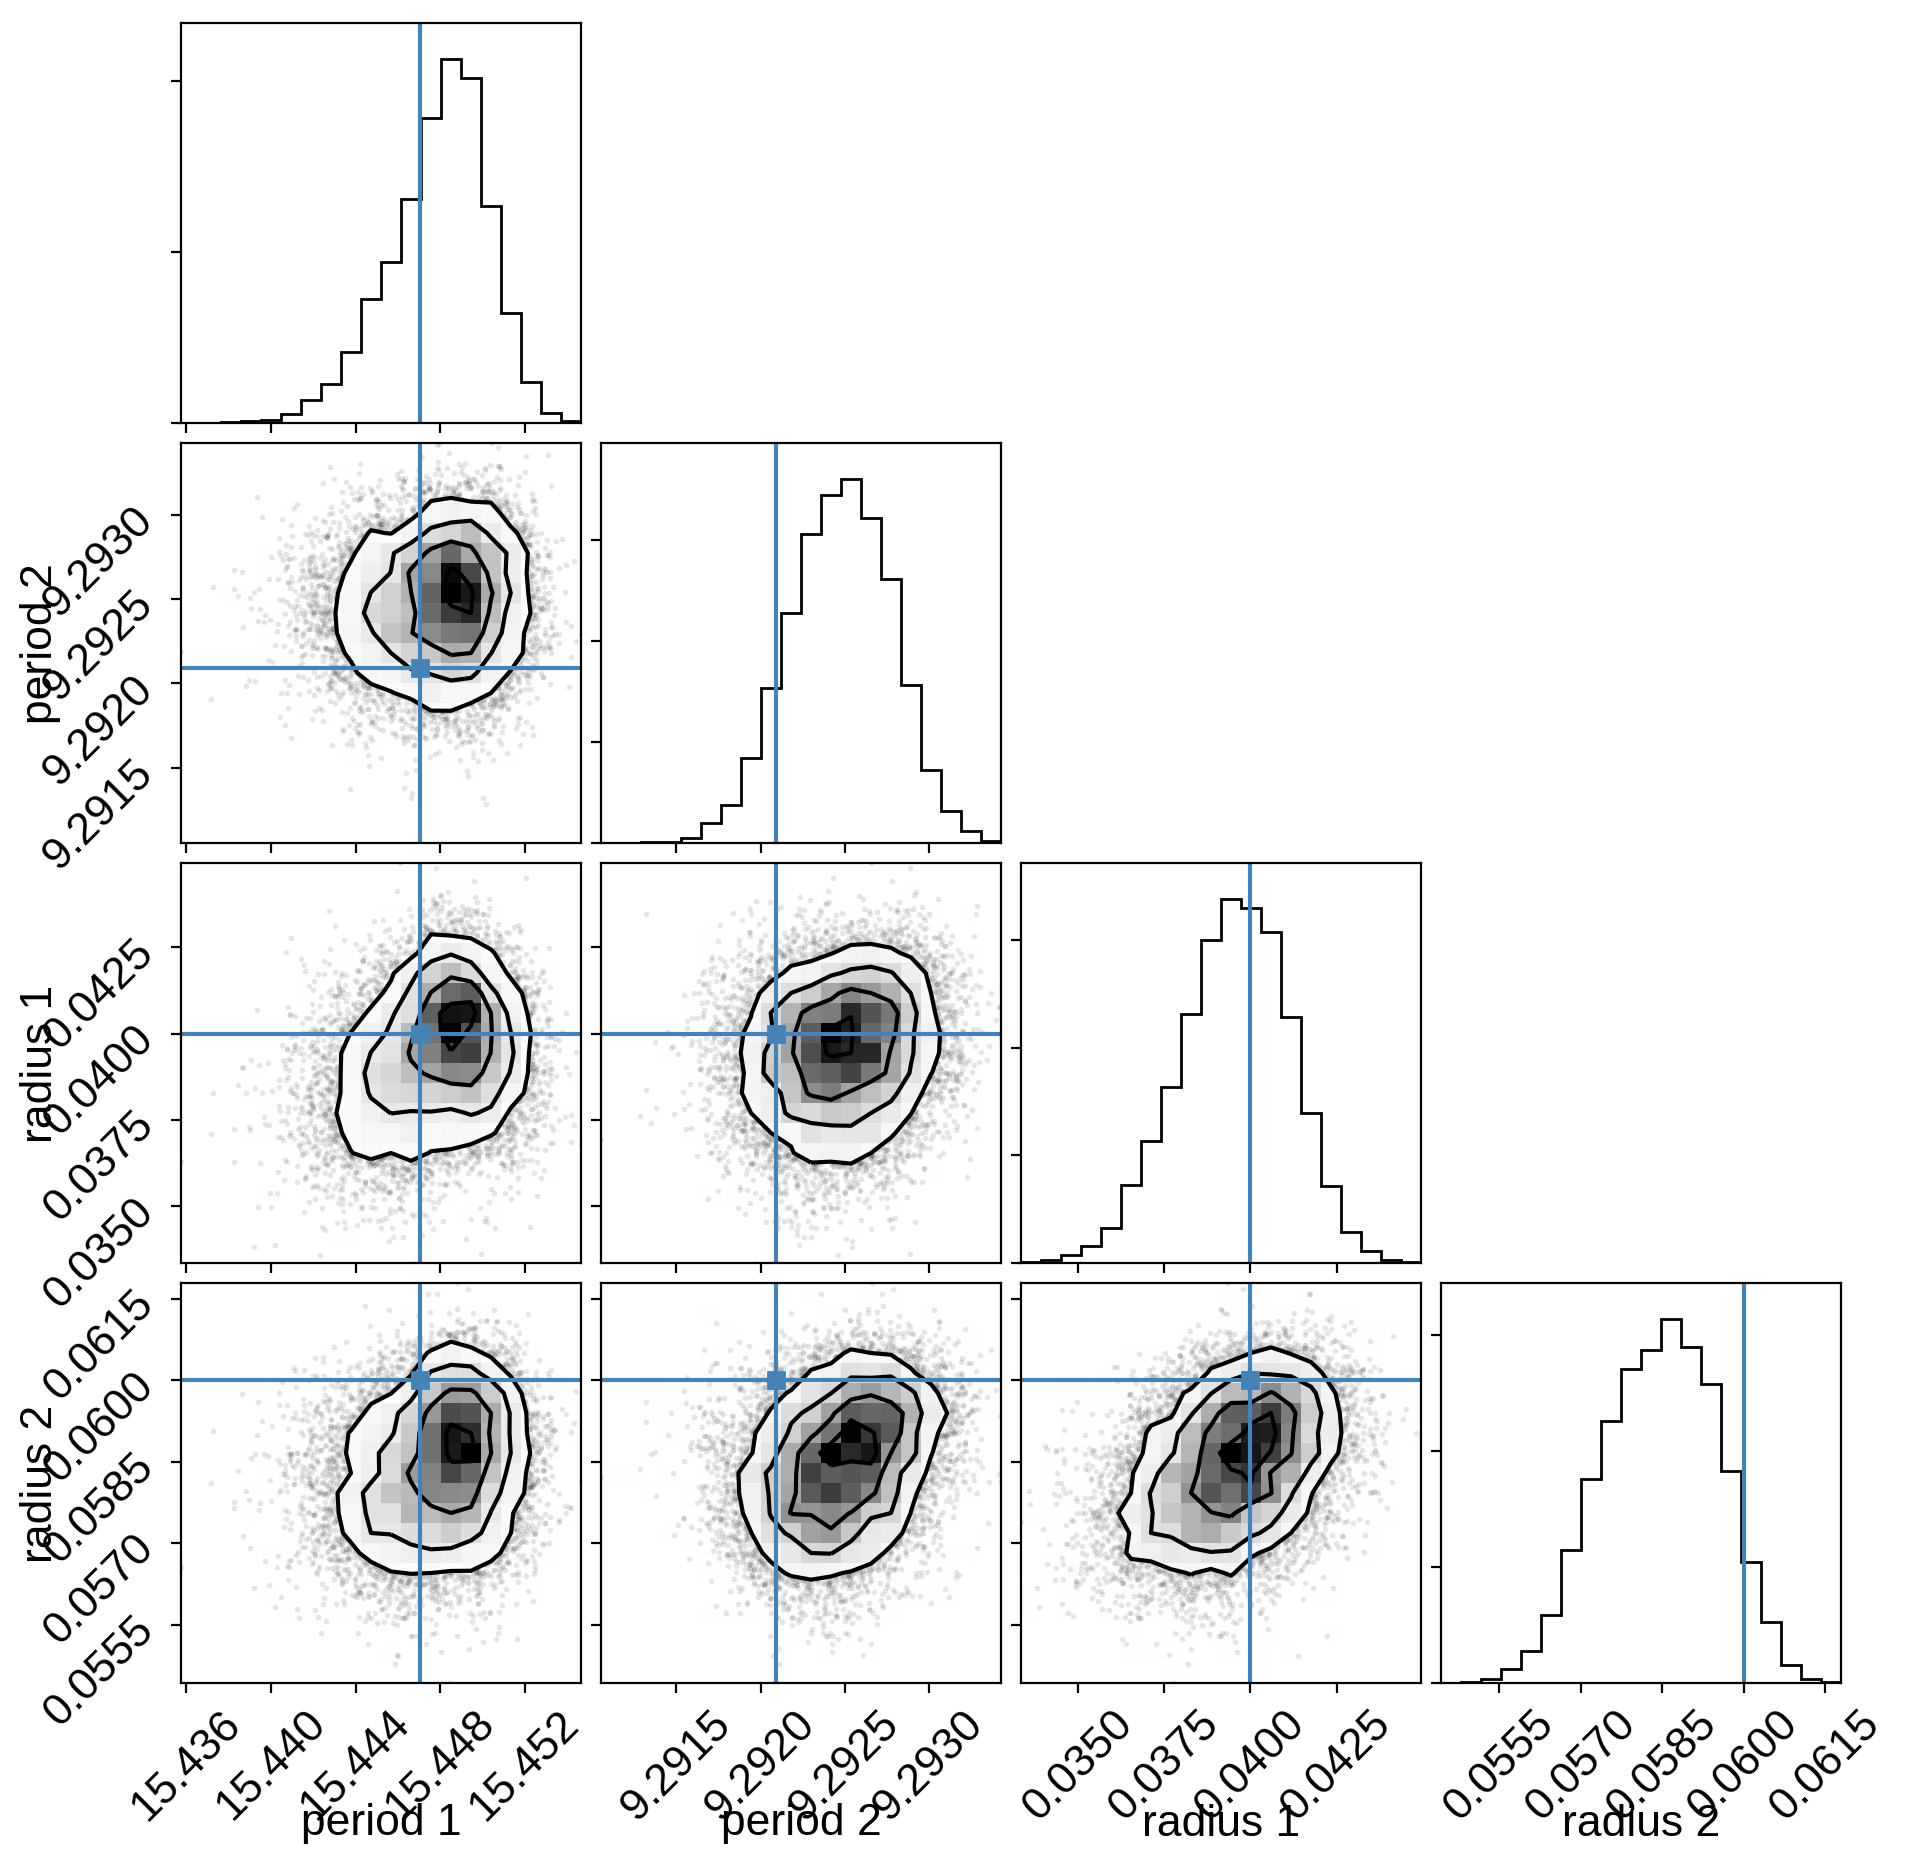

In [9]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(samples, truths=truth, labels=["period 1", "period 2", "radius 1", "radius 2"]);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

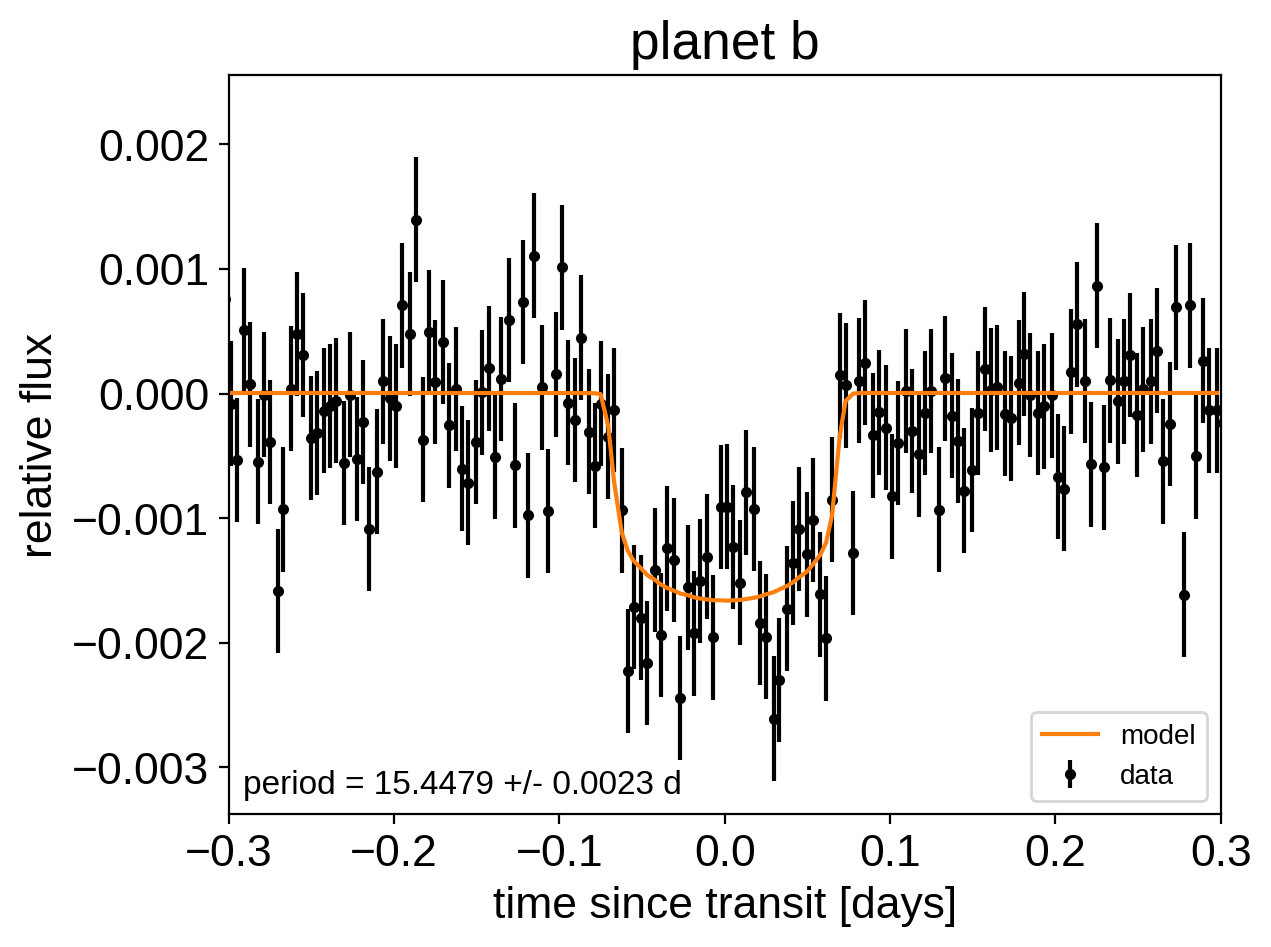

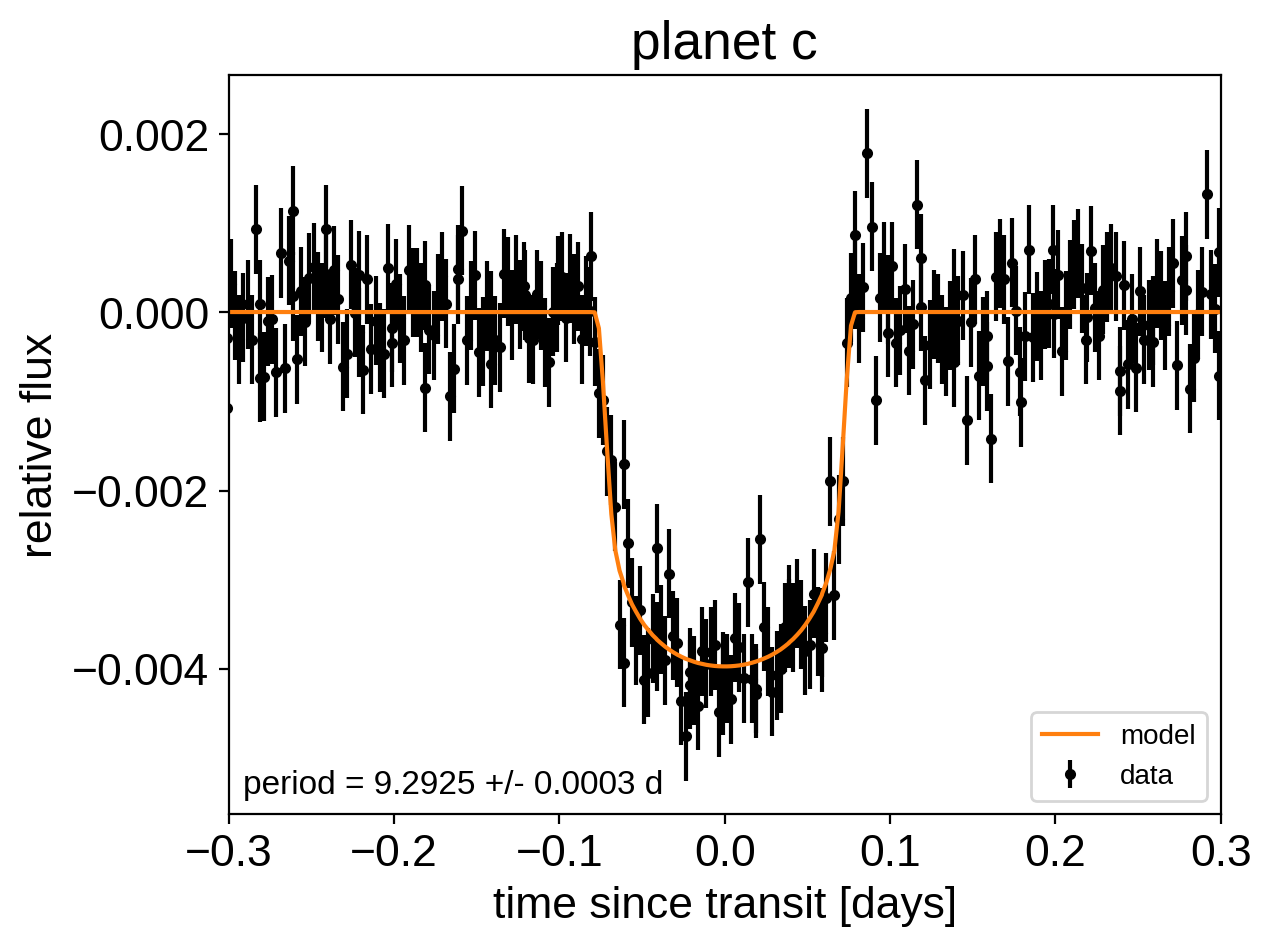

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data",
                 zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter));
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
